In [2]:
#Import data stored in Google Drive

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
#Imports

import os
import random
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import load_img
import PIL
from PIL import ImageOps
from sklearn.utils import shuffle

In [10]:
#Basic Info

img_size = (256, 256)
num_classes = 2
num_channels = 6
batch_size = 2

input_dir = '/content/drive/MyDrive/MegaNumpy' #Enter your Input Folder directory
output_dir = '/content/drive/MyDrive/Chunks/TalusChunks' #Enter your Output Folder directory
model_dir = '/content/perfecttalus.h5' #Enter your model directory

In [11]:
#Helper to iterate over the data (as Numpy arrays)

class TalusIdentifier(keras.utils.Sequence):

    def __init__(self, batch_size, img_size, input_img_paths, target_img_paths, channels):
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_img_paths = input_img_paths
        self.target_img_paths = target_img_paths
        self.channels = channels

    def __len__(self):
        return len(self.target_img_paths) // self.batch_size

    def __getitem__(self, idx):
        i = idx * self.batch_size
        batch_input_img_paths = self.input_img_paths[i : i + self.batch_size]
        batch_target_img_paths = self.target_img_paths[i : i + self.batch_size]
        x = np.zeros((self.batch_size,) + self.img_size + (6,), dtype="uint8")
        for j, path in enumerate(batch_input_img_paths):
            img = np.load(path)
            x[j] = img
        y = np.zeros((self.batch_size,) + self.img_size + (1,), dtype="uint8")
        for j, path in enumerate(batch_target_img_paths):
            img = np.array(load_img(path))[..., 0]
            y[j] = (np.expand_dims(img, 2) / 255.0).astype(np.uint8)
        
        return x, y


In [12]:
#Split Data into training/validation

input_pths = sorted(
    [
        os.path.join(input_dir, fname)
        for fname in os.listdir(input_dir)
    ]
)

target_img_paths = sorted(
    [
        os.path.join(output_dir, fname)
        for fname in os.listdir(output_dir)
    ]
)

input_pths, target_img_paths = shuffle(input_pths, target_img_paths)

# Split our img paths into a training and a validation set
val_samples = 10

train_input_img_paths = input_pths[:-val_samples]
train_target_img_paths = target_img_paths[:-val_samples]
val_input_img_paths = input_pths[-val_samples:]
val_target_img_paths = target_img_paths[-val_samples:]

# Instantiate data Sequences for each split
train_gen = TalusIdentifier(
    batch_size, img_size, train_input_img_paths, train_target_img_paths, num_channels
)

val_gen = TalusIdentifier(batch_size, img_size, val_input_img_paths, val_target_img_paths, num_channels)

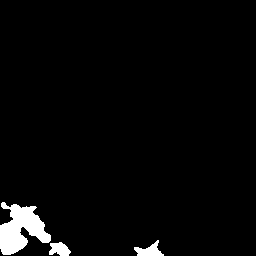

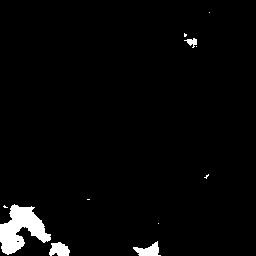

In [16]:
# Generate predictions for all images in the validation set

new_model = tf.keras.models.load_model(model_dir)

val_gen = TalusIdentifier(batch_size, img_size, val_input_img_paths, val_target_img_paths, num_channels)
val_preds = new_model.predict(val_gen)

def display_mask(i):
    """Quick utility to display a model's prediction."""
    mask = np.argmax(val_preds[i], axis=-1)
    mask = np.expand_dims(mask, axis=-1)
    img = PIL.ImageOps.autocontrast(keras.preprocessing.image.array_to_img(mask))
    display(img)

# Display results for validation image #10
i = 9 # Choose a number from 0-9 and re-run the cell to get a different test image

# Display ground-truth target mask
img = PIL.ImageOps.autocontrast(load_img(val_target_img_paths[i]))
pred_binary = np.argmax(val_preds[i], axis=-1)
display(img)

# Display mask predicted by our model
display_mask(i)  # Note that the model only sees inputs at 150x150.